In [ ]:
from sklearn.datasets import make_circles
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
n_samples = 1000 #сделать 1000 образцов
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [ ]:
circles = pd.DataFrame({'X1': X[:,0], 'X2': X[:, 1], 'label': y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


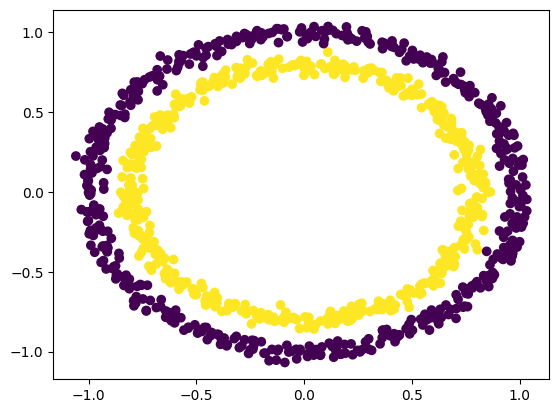

In [ ]:
plt.scatter(X[:, 0], X[:,1], c=y)

In [ ]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
len(X_train), len(X_test), len(y_train), len(y_test)


(800, 200, 800, 200)

In [ ]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=5)
    self.layer_2 = nn.Linear(in_features=5, out_features=1)

  def forward(self, x):
    return self.layer_2(self.layer_1(x))

model = CircleModelV0().to(device)
model

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [ ]:
preds = model(X_test.to(device))
preds

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [ ]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

In [ ]:
y_logits = model(X_test.to(device))[:5]
y_logits

tensor([[0.3952],
        [0.3731],
        [0.3619],
        [0.4049],
        [0.2172]], device='cuda:0', grad_fn=<SliceBackward0>)

In [ ]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5975],
        [0.5922],
        [0.5895],
        [0.5999],
        [0.5541]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
y_preds = torch.round(y_pred_probs)
y_pred_labels = torch.round(torch.sigmoid(model(X_test.to(device))[:5]))
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

In [ ]:
torch.manual_seed(42)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model.train()
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)
  if epoch % 10 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.70569, Accuracy: 50.00% | Test loss: 0.70523, Test acc: 50.00%
Epoch: 10 | Loss: 0.69760, Accuracy: 50.00% | Test loss: 0.69817, Test acc: 50.00%
Epoch: 20 | Loss: 0.69466, Accuracy: 50.00% | Test loss: 0.69567, Test acc: 50.00%
Epoch: 30 | Loss: 0.69361, Accuracy: 52.50% | Test loss: 0.69482, Test acc: 52.50%
Epoch: 40 | Loss: 0.69323, Accuracy: 54.12% | Test loss: 0.69455, Test acc: 52.00%
Epoch: 50 | Loss: 0.69309, Accuracy: 52.38% | Test loss: 0.69447, Test acc: 50.50%
Epoch: 60 | Loss: 0.69304, Accuracy: 51.75% | Test loss: 0.69446, Test acc: 48.50%
Epoch: 70 | Loss: 0.69301, Accuracy: 51.12% | Test loss: 0.69447, Test acc: 47.50%
Epoch: 80 | Loss: 0.69300, Accuracy: 50.75% | Test loss: 0.69448, Test acc: 45.50%
Epoch: 90 | Loss: 0.69300, Accuracy: 50.75% | Test loss: 0.69449, Test acc: 46.00%


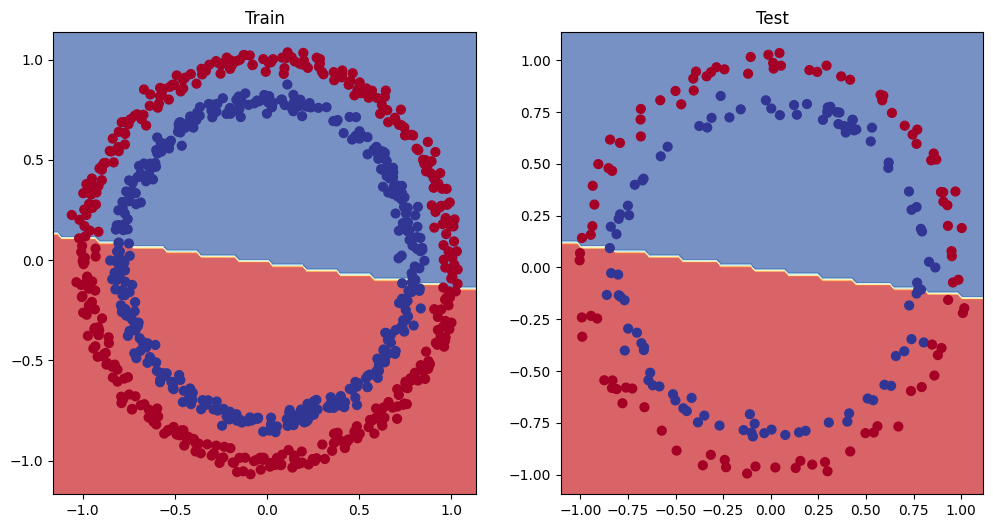

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, X_test, y_test)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

In [ ]:
from torch import nn
class CircleModelV2(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()
  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.3)

In [ ]:
torch.manual_seed(42)
epochs = 1000
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  y_logits = model_3(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_train, y_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits = model_3(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_test, test_pred)

  if epoch % 100 == 0:
    print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test Loss: 0.69306, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.68796, Accuracy: 53.00% | Test Loss: 0.68720, Test Accuracy: 56.00%
Epoch: 200 | Loss: 0.67525, Accuracy: 54.37% | Test Loss: 0.67280, Test Accuracy: 56.50%
Epoch: 300 | Loss: 0.62461, Accuracy: 73.75% | Test Loss: 0.62162, Test Accuracy: 78.50%
Epoch: 400 | Loss: 0.37448, Accuracy: 97.38% | Test Loss: 0.40781, Test Accuracy: 92.50%
Epoch: 500 | Loss: 0.36910, Accuracy: 76.75% | Test Loss: 0.45300, Test Accuracy: 73.50%
Epoch: 600 | Loss: 0.08191, Accuracy: 100.00% | Test Loss: 0.11981, Test Accuracy: 97.50%
Epoch: 700 | Loss: 0.04117, Accuracy: 100.00% | Test Loss: 0.06974, Test Accuracy: 99.00%
Epoch: 800 | Loss: 0.02686, Accuracy: 100.00% | Test Loss: 0.04934, Test Accuracy: 99.00%
Epoch: 900 | Loss: 0.01987, Accuracy: 100.00% | Test Loss: 0.04013, Test Accuracy: 99.00%


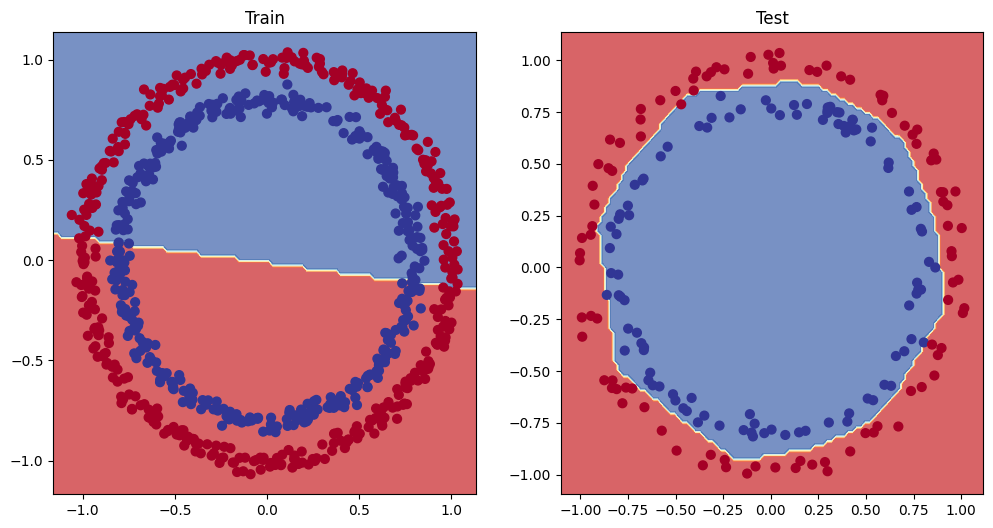

In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test)